<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/ModNets%20/Latent/DZ_1_latent_diffusion_part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Домашнее задание: реализация модели latent diffusion

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
BASE_PATH = '/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/Современные модели DL/Latent/'

In [3]:
!nvidia-smi

Sun Oct 22 13:37:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%pip install --quiet --upgrade diffusers transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.9 MB/s eta 0:00:00


In [ ]:
%pip install torchsde

In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [71]:
# yoimport os
import json
from tqdm import tqdm
import torch
import torchsde
from PIL import Image, ImageDraw, ImageFont

from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers.schedulers import *


# Accelerator

In [6]:
#from accelerate import Accelerator
#accelerator = Accelerator()#fp16=True)
DEVICE = 'cuda' #accelerator.device
#DEVICE

### [2 балла] Анализ влияния scheduler на качество генерации

 На качество генерации может влиять используемый scheduler и число шагов, поэтому в этой части домашнего задания, вам предлагается происследовать визуально как scheduler и число шагов влияют на качество генерации. Вам предлагается рассмотреть качество генерации на 10 различных числах шагов и,  используя различные scheduler.


 В качестве scheduler предлагается стандартный DDPM, DDIM, DPMSolver (Другие scheduler не воспрещаются). Обратите внимание, что DDIM и DPMSolver являются детерминированными scheduler, а значит результат у них должен получаться одиннаковый.

 **Ожидаемый результат**

 В качестве результатов в этом пункте от вас требуется предоставить визуализации картинок в различных вариации числа шагов и scheduler и сделать выводы, какие параметры лучше использовать. Вы можете выполнить эту часть, не используя обученную выше модель, а используя стандартные pipeline StableDiffusion

In [7]:
# helper function to draw an image grid
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i//rows*w, i%rows*h))
    return grid

# set up the callback that saves intermediate results
def callback(iter, t, latents):
    # convert latents to image
    with torch.no_grad():
        latents = 1 / 0.18215 * latents
        image = pipeline.vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        image = pipeline.numpy_to_pil(image)
        if iter in iter_images:
            iter_images[iter].append(image[0])
        else:
            iter_images[iter] = [image[0]]

In [40]:
# define model params and the PROMPT
prompt = "Mickle Jackson as fisherman, realistic portrait, skull on vest, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, cinematic lighting, art by artgerm and greg rutkowski and alphonse mucha"
guid_scale = 7.5
num_steps = 100
steps_to_check = 4
height = 768
widht = 512
num_images = 1
seed = 139

# define paths and initialize SD model
pipeline = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",
                                                   torch_dtype=torch.float16)
pipeline = pipeline.to(DEVICE)
pipeline.set_progress_bar_config(disable=True)



# keep scheduler config of the imported pipeline to reuse
config = pipeline.scheduler.config

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [88]:
compatible_schedulers = pipeline.scheduler.compatibles
compatible_schedulers[5]

diffusers.utils.dummy_torch_and_torchsde_objects.DPMSolverSDEScheduler

In [89]:
compatible_schedulers = compatible_schedulers[:5] + compatible_schedulers[:5]
compatible_schedulers

[diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler]

In [23]:
compatible_schedulers[0].__name__

'DPMSolverMultistepScheduler'

In [28]:
import matplotlib
system_fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

font = ImageFont.truetype(system_fonts[0], 60)

In [ ]:
system_fonts

['/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf',
 '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/Li

In [90]:
# iterate over all compatible schedulers
names_pass = ["HeunDiscreteScheduler", "DPMSolverSDEScheduler"]
import os
for i in range(len(compatible_schedulers)):
    name_scheduler = compatible_schedulers[i].__name__
    print(f"Running with {name_scheduler} scheduler")
    try:
        # instantiate new scheduler
        scheduler = compatible_schedulers[i].from_config(config)

        # this scheduler behaves very weird, exclude it
        if name_scheduler in names_pass:
            print(f"pass {name_scheduler}")
            continue
        # patch current pipeline
        pipeline.scheduler = scheduler
        g_cuda = torch.Generator(device=DEVICE).manual_seed(seed)
        # map to track images during denoising steps
        iter_images = {}
        callback_steps = num_steps // steps_to_check

        with torch.autocast(DEVICE), torch.inference_mode():
            final_step_imgs = []
            for i in tqdm(range(num_images), desc="Generating samples"):
                image = pipeline(
                    prompt,
                    guidance_scale=guid_scale,
                    num_inference_steps=num_steps,
                    num_images_per_prompt=1,
                    generator=g_cuda,
                    callback=callback,
                    callback_steps=callback_steps,
                ).images[0]
                final_step_imgs.append(image)

            if num_steps not in iter_images:
                iter_images[num_steps] = final_step_imgs

            images = []
            # need to download the arial.ttf font from the internet
            #font = ImageFont.FreeTypeFont #ImageFont.truetype("./arial.ttf", 40)

            for iter_step in sorted(iter_images.keys()):
                step_images = iter_images[iter_step]
                #draw = ImageDraw.Draw(step_images[0])
                #draw.rectangle(bbox, fill="red")
              # draw.text((10, 10),f"Step {iter_step:03}",(255,0,0),font=font, fill="white")
                text = f"Step {iter_step:03}"
                position = (10, 10)
                draw = ImageDraw.Draw(step_images[0])
                left, top, right, bottom = draw.textbbox(position, text, font=font)
                draw.rectangle((left-5, top-5, right+5, bottom+5), fill="red")
                draw.text(position, text, font=font, fill="black")
                # write on top of the images
                images.extend(step_images)

            # draw a grid to file
            rows = num_images
            cols = len(iter_images.keys())
            grid = image_grid(images, rows, cols)
            draw = ImageDraw.Draw(grid)
          # draw.text((10, 80),f"With {compatible_schedulers[i].__name__} scheduler",(255,0,0),font=font)#, fill="white")
            text =f"With {name_scheduler} scheduler"
            position = (10, 80)
            left, top, right, bottom = draw.textbbox(position, text, font=font)
            draw.rectangle((left-5, top-5, right+5, bottom+5), fill="red")
            draw.text(position, text, font=font, fill="black")

            # Сохраняем изображения
            path = BASE_PATH + f"test_schedulers/out_txt2img_{name_scheduler}_{i}.png"
            print(f'Save to {path}')
            grid.save(path)
            print()
            names_pass+=[name_scheduler] #to pass with same name



    except Exception as ex:
      # debuggin stuff
      print(f"Error {name_scheduler} scheduler")
      print(ex)
      import pdb; pdb.set_trace()

Running with UniPCMultistepScheduler scheduler


Generating samples: 100%|██████████| 1/1 [00:19<00:00, 19.89s/it]


Save to /content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/Современные модели DL/Latent/test_schedulers/out_txt2img_UniPCMultistepScheduler_0.png

Running with DPMSolverMultistepScheduler scheduler


Generating samples: 100%|██████████| 1/1 [00:18<00:00, 18.58s/it]


Save to /content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/Современные модели DL/Latent/test_schedulers/out_txt2img_DPMSolverMultistepScheduler_0.png

Running with KDPM2AncestralDiscreteScheduler scheduler


Generating samples: 100%|██████████| 1/1 [00:34<00:00, 34.97s/it]


Save to /content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/Современные модели DL/Latent/test_schedulers/out_txt2img_KDPM2AncestralDiscreteScheduler_0.png

Running with DEISMultistepScheduler scheduler


Generating samples: 100%|██████████| 1/1 [00:18<00:00, 18.14s/it]


Save to /content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/Современные модели DL/Latent/test_schedulers/out_txt2img_DEISMultistepScheduler_0.png

Running with DPMSolverSinglestepScheduler scheduler


Generating samples: 100%|██████████| 1/1 [00:17<00:00, 17.80s/it]


Save to /content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/Современные модели DL/Latent/test_schedulers/out_txt2img_DPMSolverSinglestepScheduler_0.png

Running with UniPCMultistepScheduler scheduler
pass UniPCMultistepScheduler
Running with DPMSolverMultistepScheduler scheduler
pass DPMSolverMultistepScheduler
Running with KDPM2AncestralDiscreteScheduler scheduler
pass KDPM2AncestralDiscreteScheduler
Running with DEISMultistepScheduler scheduler
pass DEISMultistepScheduler
Running with DPMSolverSinglestepScheduler scheduler
pass DPMSolverSinglestepScheduler


# ВЫВОД

Все шумы и вариации подачи и шагов просто нет времени проверить.

Но зато теперь есть инструмент для теста

Сильно меняет генерацию - `KDPM2AncestralDiscreteScheduler ` scheduler

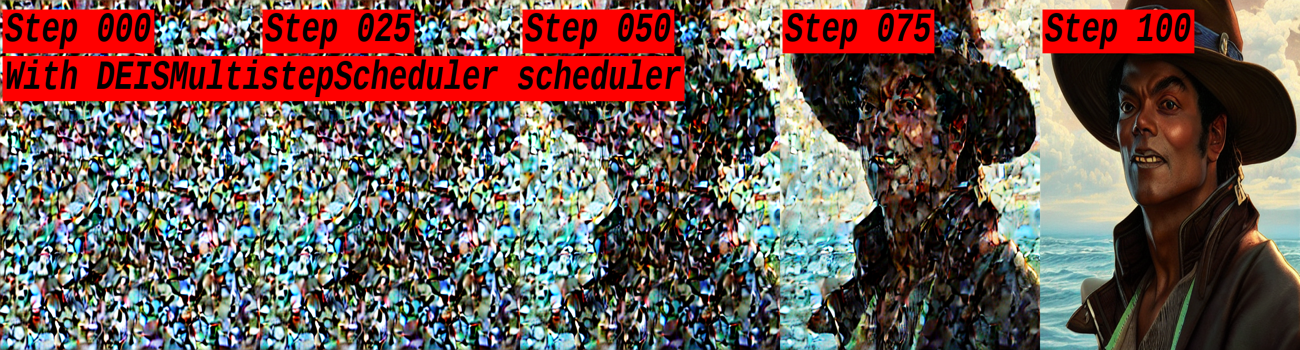

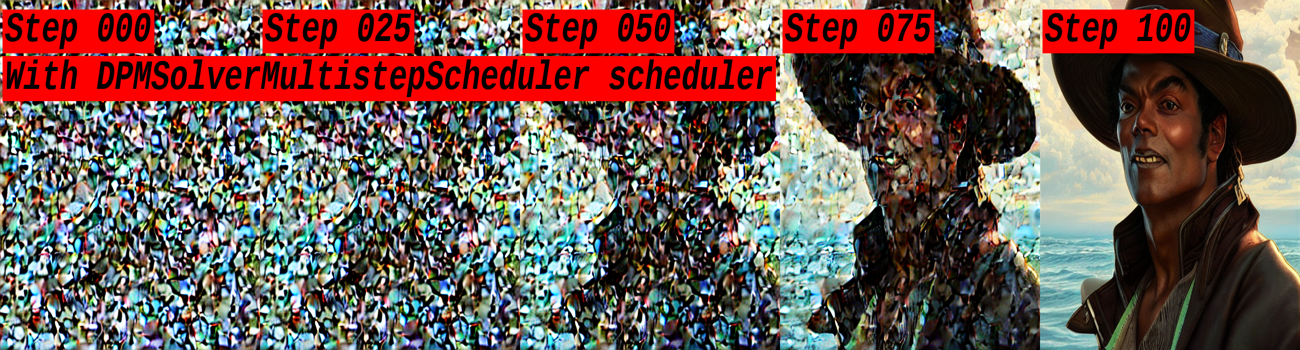

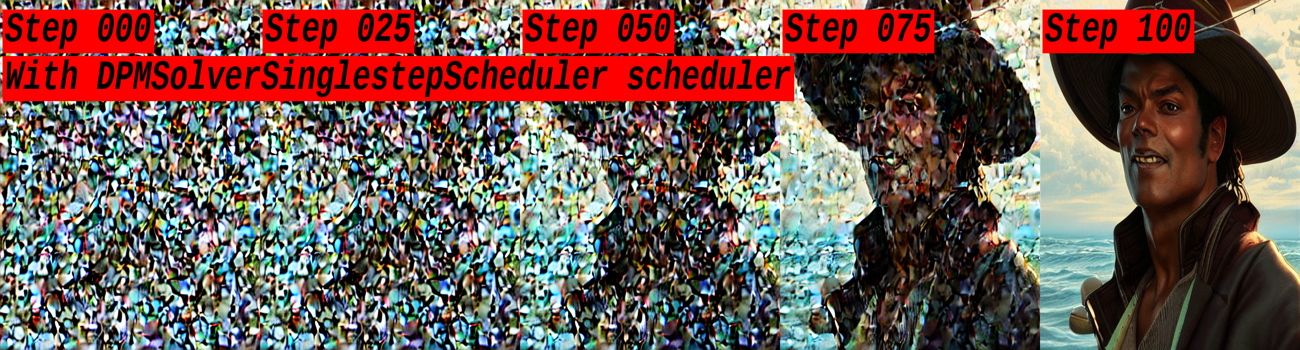

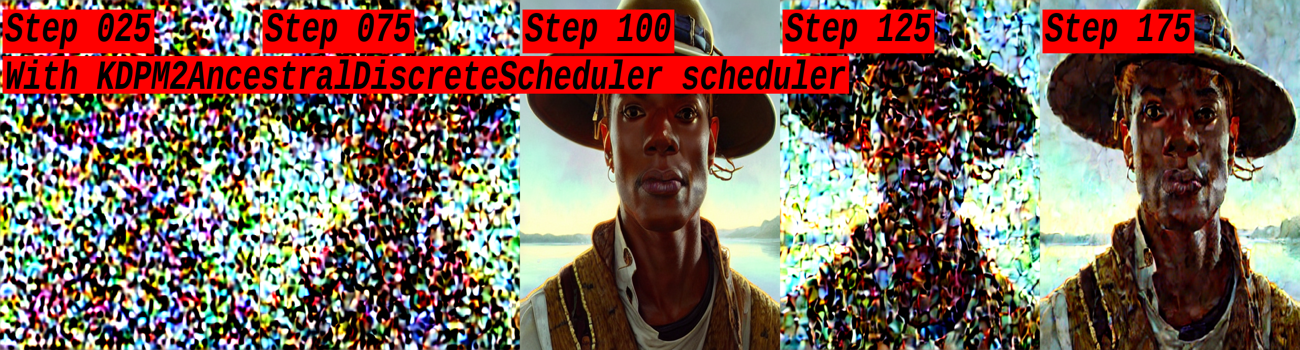

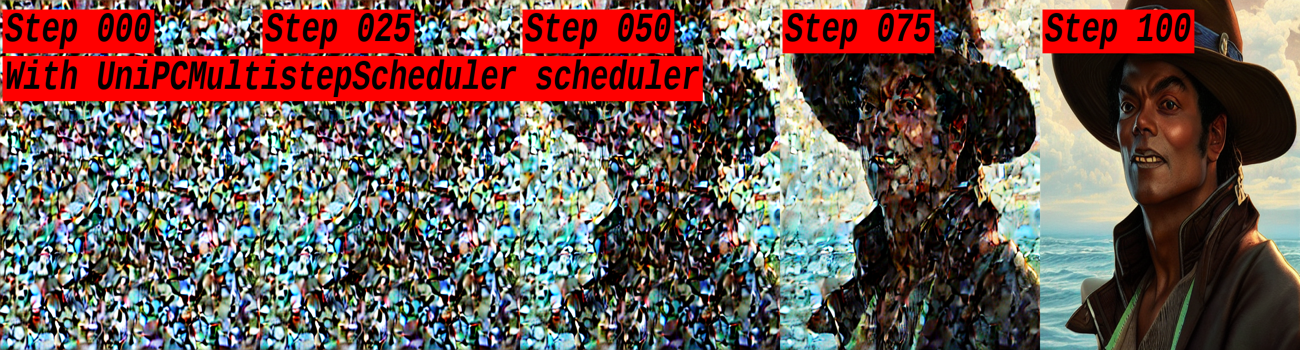

In [91]:
import glob

sample_images = sorted(glob.glob(f"{BASE_PATH}/test_schedulers/*.png")) #BASE_PATH + f"test_sschedulers
for test in sample_images:
  display(Image.open(test).resize((1300,350)))
  print()